In [1]:
from __future__ import print_function
import time
import pickle
import argparse, math, random

#data science frameworks
import numpy as np
import pandas as pd 
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

#plot tools
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

#pytorch, neural networks
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
from torch import optim
from torch.autograd import Variable

#append paths, scripts for adversarial training
import sys
sys.path.append('../adversarial/')
sys.path.append('../architectures/')
from functional import boundary, iterated_fgsm, local_search, pgd, entropySmoothing, fgsm
from ESGD_utils import *
import ESGD_optim
from trades import trades_loss

In [39]:
from itertools import product

In [2]:
transform = transforms.ToTensor()
train = datasets.MNIST('../../data/MNIST', train=True, transform=transform, download=True)
val = datasets.MNIST('../../data/MNIST', train=False, transform=transform, download=True)

In [3]:
Xtens = torch.zeros([10000,1,28,28])
y = torch.zeros([10000])
for i in range(len(val)):
    Xtens[i,:,:,:],y[i] = val[i]

In [4]:
X = Xtens.view(-1,784)

## PCA

In [5]:
if False:
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(X)
    pc1 = pca_result[:,0]
    pc2 = pca_result[:,1] 
    pc3 = pca_result[:,2]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    #Explained variation per principal component: [0.09730166 0.07135901 0.06183721]

In [6]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 3.171s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.129212
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.019302
[t-SNE] KL divergence after 300 iterations: 2.777418
t-SNE done! Time elapsed:

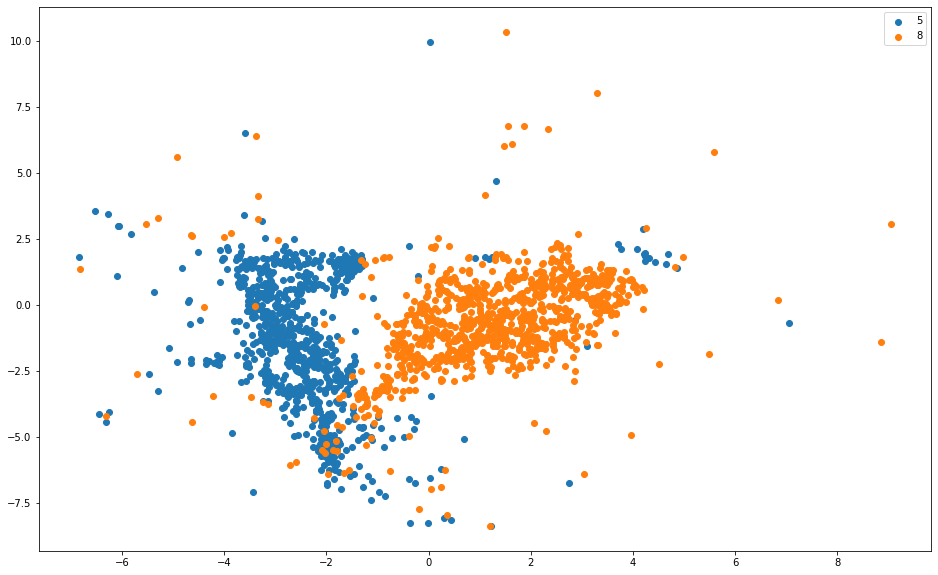

In [7]:
ts1 = tsne_results[:,0]
ts2 = tsne_results[:,1]
plt.figure(figsize=(16,10))
leg= []
for i in [5,8]:    
    ind = torch.where(y==i)
    if i ==5:
        xdata = tsne_results[ind]
        ydata = y[ind]
    elif i==8:
        xdata = np.concatenate([xdata,tsne_results[ind]],0)
        ydata = torch.cat([ydata,y[ind]],0)
    plt.scatter(ts1[ind], ts2[ind], marker='o')
    leg.append(str(i))
plt.legend(leg)

In [8]:
d = len(ydata)
ii = torch.randperm(d)

### shuffle data

In [9]:
ydata = ydata[ii]
xdata = xdata[ii]

### convert to two class classification problem

In [10]:
ydata[ydata==5]=0
ydata[ydata==8]=1

### build data loader


In [11]:
class MNISTminiDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, xdata,ydata, transform=None):
       
        self.xdata = xdata
        self.ydata = ydata
        self.transform = transform

    def __len__(self):
        return len(self.ydata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = torch.tensor(self.xdata[idx]).unsqueeze(0)
        labels = torch.tensor(self.ydata[idx]).long()

        return image, labels

In [12]:
f = 0.7 #train test split
tr_ind = np.ceil(f*d).astype(int)
print('No. of training samples:',tr_ind)

No. of training samples: 1307


In [13]:
ts_d = d-tr_ind

In [14]:
print('No. of test samples:',ts_d)

No. of test samples: 559


### training hyperparams

In [15]:
args = {}
args['test_batch_size'] = 32
args['batch_size'] = 32
args['no_cuda'] = True
args['seed'] = 1
# attack params
args['attack'] = 'l_inf' 
args['epsilon'] = 1
args['num_steps'] = 40
args['step_size'] = 0.1
args['random'] =True
args['white_box_attack']=True
#TRADES
args['beta'] = 8.0
# adversarial training
args['lr'] = 0.01
args['momentum'] = 0.9
args['epochs'] = 30

### create train and test loaders

In [16]:
train = MNISTminiDataset(xdata[:tr_ind],ydata[:tr_ind])
train_loader = DataLoader(train, batch_size=args['batch_size'], shuffle=True)
test = MNISTminiDataset(xdata[tr_ind:],ydata[tr_ind:])
test_loader = DataLoader(test, batch_size=args['test_batch_size'], shuffle=True)

### create a small two layer network

In [17]:
class twolayer(nn.Module):
    def __init__(self):
        super(twolayer, self).__init__()
        self.conv1 = nn.Conv1d(1, 20, kernel_size=2,padding=2)
        self.fc1 = nn.Linear(100,150)
        self.fc2 = nn.Linear(150, 2)

    def forward(self, x):
        #print(x.shape)
        x = torch.relu(self.conv1(x))
        #print(x.shape)
        x = x.view(-1, 100)
        #print(x.shape)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### modules to evaluate train and test performance

In [18]:
def eval_train(model, device, train_loader):
    model.eval()
    train_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            train_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    print('Training: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    training_accuracy = correct / len(train_loader.dataset)
    return train_loss, training_accuracy

In [19]:
def eval_test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [20]:
def infnorm(x):
    infn = torch.max(torch.abs(x.detach().cpu()))
    return infn

In [21]:
def _pgd_whitebox(model,
                  X,
                  y,
                  epsilon=args['epsilon'],
                  num_steps=args['num_steps'],
                  step_size=args['step_size'],
                  random=args['random']):
    out = model(X)
    err = (out.data.max(1)[1] != y.data).float().sum()
    X_pgd = Variable(X.data, requires_grad=True)
    if random:
        random_noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(DEVICE)
        X_pgd = Variable(X_pgd.data + random_noise, requires_grad=True)

    for _ in range(num_steps):
        opt = optim.SGD([X_pgd], lr=1e-3)
        opt.zero_grad()

        with torch.enable_grad():
            loss = nn.CrossEntropyLoss()(model(X_pgd), y)
        loss.backward()
        eta = step_size * X_pgd.grad.data.sign()
        X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
        eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
        X_pgd = Variable(X.data + eta, requires_grad=True)
        X_pgd = Variable(torch.clamp(X_pgd, -10.0, 10.0), requires_grad=True)
        #print('attack dist:',infnorm(X-X_pgd))     
    err_pgd = (model(X_pgd).data.max(1)[1] != y.data).float().sum()
    #print('err pgd (white-box): ', err_pgd)
    return err, err_pgd

def eval_adv_test_whitebox(model, device, test_loader):
    """
    evaluate model by white-box attack
    """
    model.eval()
    robust_err_total = 0
    natural_err_total = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        # pgd attack
        X, y = Variable(data, requires_grad=True), Variable(target)
        err_natural, err_robust = _pgd_whitebox(model, X, y)
        robust_err_total += err_robust
        natural_err_total += err_natural
    rob = 100-robust_err_total.item()*100/ts_d    
    nat = 100-natural_err_total.item()*100/ts_d
    print('natural_acc_total: {:.2f}'.format(nat))
    print('robust_acc_total: {:.2f}'.format(rob))
    return rob,nat

In [22]:
def train_adversarial(method,model, device, train_loader, optimizer, epoch,adversary,L,step,eps,norm):
    totalcorrect = 0
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)
        ypred = model(data)
        
        sgd_loss = nn.CrossEntropyLoss()
        # calculate robust loss per batch
        loss, correct = method(model,optimizer,sgd_loss,data,target,epoch,adversary,L,step,eps,norm)
        totalcorrect += correct
    print('robust train accuracy:',100*totalcorrect/len(train_loader.dataset))   

In [23]:
def trainsgd(model, device, train_loader, optimizer):
    totalcorrect = 0
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)
        model.train()
        optimizer.zero_grad()
        ypred = model(data)
        pred = ypred.max(1, keepdim=True)[1]
        lossfn = torch.nn.CrossEntropyLoss()
        train_loss = lossfn(ypred, target)
        correct = pred.eq(target.view_as(pred)).sum().item()
        totalcorrect +=correct
        
        train_loss.backward()
        optimizer.step()
            

In [24]:
def adversarial_training_entropy(model, optimiser, loss_fn, x, y, epoch, adversary, L, step, eps, norm):
    """Performs a single update against a specified adversary"""
    model.train()
    
    # Adversial perturbation
    alpha=0.9         
    loss = 0
    
    for l in range(L):     
        if l==0: ## initialize using random perturbation of true x, run for one epoch
            k=1
            random=False #true
            xp = x
            projector=False
        elif l>0 and l<L-1: ## initialize with previous iterate of adversarial perturbation, run one epoch
            k=1
            random=False
            xp=x_adv
            projector = False
        elif l == L-1: ## initialize with previous iterate, run one epoch, project to epsilon ball
            k=1
            random=False
            xp = x_adv
            projector=True
            
        x_adv = adversary(model, x, y, loss_fn, xp=xp, step=step, eps=eps, norm=norm, random=random, ep=1e-9,projector=projector,clamp=(-10,10))
        
        optimiser.zero_grad()
        y_pred = model(x_adv)
        pred = y_pred.max(1, keepdim=True)[1]
        correct = pred.eq(y.view_as(pred)).sum().item()
        loss = (1-alpha)*loss + alpha*loss_fn(y_pred, y)
    loss.backward()
    optimiser.step()
    return loss, correct

In [25]:
def adversarial_training(model, optimiser, loss_fn, x, y, epoch, adversary, k, step, eps, norm):

    """Performs a single update against a specified adversary"""
    model.train()
    
    # Adversial perturbation
    x_adv = adversary(model, x, y, loss_fn, k=k, step=step, eps=eps, norm=norm, random=True)
    
    optimiser.zero_grad()
    y_pred = model(x_adv)
    pred = y_pred.max(1, keepdim=True)[1]
    correct = pred.eq(y.view_as(pred)).sum().item()
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimiser.step()

    return loss, correct

In [26]:
DEVICE = 'cpu'

In [27]:
def adjust_learning_rate(optimizer, epoch,lr_init):
    """decrease the learning rate"""
    lr = lr_init
    if epoch >= 25:   
        lr = lr_init * 0.1
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [28]:
def train_trades(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # calculate robust loss
        loss = trades_loss(model=model,
                           x_natural=data,
                           y=target,
                           optimizer=optimizer,
                           step_size=args['step_size'],
                           epsilon=args['epsilon'],
                           perturb_steps=args['num_steps'],
                           beta=args['beta'])

        loss.backward()
        optimizer.step()

In [29]:
## initialize model
model_TRADES = twolayer().to(DEVICE)
## training params
lr = args['lr']
optimizer = optim.SGD(model_TRADES.parameters(), lr=lr, momentum=0.9)
epochs = args['epochs']

## train model
for epoch in range(1, epochs + 1):
    print('Epoch:',epoch)
    # adjust learning rate for SGD
    adjust_learning_rate(optimizer, epoch, lr_init=lr)

    # adversarial training
    train_trades(args, model_TRADES, DEVICE, train_loader, optimizer, epoch)

    # evaluation on natural examples
    print('================================================================')
    rob1,nat1 = eval_adv_test_whitebox(model_TRADES, DEVICE, test_loader)
    print('================================================================')

Epoch: 1


<ipython-input-11-1071b6ee65c1>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.ydata[idx]).long()
/home/gauri/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


natural_acc_total: 94.10
robust_acc_total: 67.62
Epoch: 2
natural_acc_total: 87.30
robust_acc_total: 62.61
Epoch: 3
natural_acc_total: 88.55
robust_acc_total: 70.13
Epoch: 4
natural_acc_total: 89.62
robust_acc_total: 68.69
Epoch: 5
natural_acc_total: 92.31
robust_acc_total: 74.42
Epoch: 6
natural_acc_total: 91.41
robust_acc_total: 64.58
Epoch: 7
natural_acc_total: 88.73
robust_acc_total: 70.84
Epoch: 8
natural_acc_total: 89.98
robust_acc_total: 72.27
Epoch: 9
natural_acc_total: 91.06
robust_acc_total: 69.95
Epoch: 10
natural_acc_total: 91.41
robust_acc_total: 69.95
Epoch: 11
natural_acc_total: 89.98
robust_acc_total: 72.09
Epoch: 12
natural_acc_total: 91.95
robust_acc_total: 67.08
Epoch: 13
natural_acc_total: 89.80
robust_acc_total: 72.09
Epoch: 14
natural_acc_total: 92.13
robust_acc_total: 73.35
Epoch: 15
natural_acc_total: 89.45
robust_acc_total: 71.02
Epoch: 16
natural_acc_total: 89.98
robust_acc_total: 71.56
Epoch: 17
natural_acc_total: 87.66
robust_acc_total: 72.09
Epoch: 18
natur

In [30]:
## training params
model_PGD=twolayer()

epochs = args['epochs'] 
lr_init = args['lr'] #0.003
optimizer = optim.SGD(model_PGD.parameters(), lr=lr_init, momentum=0.9)

## train model
for epoch in range(1, epochs+1):
    print('Epoch:',epoch)
    # adjust learning rate for SGD
    adjust_learning_rate(optimizer, epoch,lr_init) 
    
    # adversarial training
    train_adversarial(adversarial_training,model_PGD, DEVICE, train_loader, optimizer, epoch,adversary=pgd,L=args['num_steps'],step=args['step_size'],eps=args['epsilon'],norm='inf')
   
    # evaluation on natural and adversarial examples
    print('================================================================')
    eval_train(model_PGD, DEVICE, train_loader)
    rob3,nat3 = eval_adv_test_whitebox(model_PGD, DEVICE, test_loader)            
    print('================================================================')

Epoch: 1


<ipython-input-11-1071b6ee65c1>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.ydata[idx]).long()


robust train accuracy: 61.514919663351186
Training: Average loss: 0.4071, Accuracy: 1110/1307 (85%)
natural_acc_total: 83.90
robust_acc_total: 70.13
Epoch: 2
robust train accuracy: 68.5539403213466
Training: Average loss: 0.3673, Accuracy: 1110/1307 (85%)
natural_acc_total: 84.44
robust_acc_total: 70.84
Epoch: 3
robust train accuracy: 72.99158377964805
Training: Average loss: 0.3708, Accuracy: 1128/1307 (86%)
natural_acc_total: 86.23
robust_acc_total: 71.38
Epoch: 4
robust train accuracy: 73.29762815608264
Training: Average loss: 0.4394, Accuracy: 1103/1307 (84%)
natural_acc_total: 84.44
robust_acc_total: 70.13
Epoch: 5
robust train accuracy: 72.9150726855394
Training: Average loss: 0.4347, Accuracy: 1107/1307 (85%)
natural_acc_total: 84.79
robust_acc_total: 71.20
Epoch: 6
robust train accuracy: 73.22111706197398
Training: Average loss: 0.4603, Accuracy: 1105/1307 (85%)
natural_acc_total: 84.44
robust_acc_total: 70.66
Epoch: 7
robust train accuracy: 73.14460596786535
Training: Average 

natural_acc_total: 86.05
robust_acc_total: 72.09
Epoch: 30
robust train accuracy: 73.83320581484315
Training: Average loss: 0.5785, Accuracy: 1118/1307 (86%)
natural_acc_total: 86.23
robust_acc_total: 72.09


In [31]:
## training params
model_ATENT=twolayer()

epochs = args['epochs'] 
lr_init = args['lr'] #0.003
optimizer = optim.SGD(model_ATENT.parameters(), lr=lr_init, momentum=0.9)

## train model
for epoch in range(1, epochs+1):
    print('Epoch:',epoch)
    # adjust learning rate for SGD
    adjust_learning_rate(optimizer, epoch,lr_init) 
    
    # adversarial training
    train_adversarial(adversarial_training_entropy,model_ATENT, DEVICE, train_loader, optimizer, epoch,adversary=entropySmoothing,L=args['num_steps'],step=args['step_size'],eps=args['epsilon'],norm='inf')
   
    # evaluation on natural and adversarial examples
    print('================================================================')
    eval_train(model_ATENT, DEVICE, train_loader)
    eval_test(model_ATENT, DEVICE, test_loader)
    rob,nat = eval_adv_test_whitebox(model_ATENT, DEVICE, test_loader)            
    print('================================================================')

Epoch: 1


<ipython-input-11-1071b6ee65c1>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.ydata[idx]).long()


robust train accuracy: 70.08416220351951
Training: Average loss: 0.4372, Accuracy: 1158/1307 (89%)
Test: Average loss: 0.4380, Accuracy: 498/559 (89%)
natural_acc_total: 89.09
robust_acc_total: 74.06
Epoch: 2
robust train accuracy: 76.66411629686304
Training: Average loss: 0.4753, Accuracy: 1219/1307 (93%)
Test: Average loss: 0.4712, Accuracy: 523/559 (94%)
natural_acc_total: 93.56
robust_acc_total: 72.81
Epoch: 3
robust train accuracy: 74.82785003825555
Training: Average loss: 0.4308, Accuracy: 1197/1307 (92%)
Test: Average loss: 0.4244, Accuracy: 520/559 (93%)
natural_acc_total: 93.02
robust_acc_total: 74.42
Epoch: 4
robust train accuracy: 75.66947207345065
Training: Average loss: 0.4102, Accuracy: 1177/1307 (90%)
Test: Average loss: 0.4004, Accuracy: 510/559 (91%)
natural_acc_total: 91.23
robust_acc_total: 74.96
Epoch: 5
robust train accuracy: 78.2708492731446
Training: Average loss: 0.3741, Accuracy: 1198/1307 (92%)
Test: Average loss: 0.3638, Accuracy: 522/559 (93%)
natural_acc_to

natural_acc_total: 93.02
robust_acc_total: 72.81
Epoch: 26
robust train accuracy: 77.5822494261668
Training: Average loss: 0.3584, Accuracy: 1194/1307 (91%)
Test: Average loss: 0.3458, Accuracy: 520/559 (93%)
natural_acc_total: 93.02
robust_acc_total: 72.27
Epoch: 27
robust train accuracy: 77.88829380260138
Training: Average loss: 0.3567, Accuracy: 1195/1307 (91%)
Test: Average loss: 0.3444, Accuracy: 520/559 (93%)
natural_acc_total: 93.02
robust_acc_total: 72.09
Epoch: 28
robust train accuracy: 77.81178270849273
Training: Average loss: 0.3558, Accuracy: 1196/1307 (92%)
Test: Average loss: 0.3431, Accuracy: 520/559 (93%)
natural_acc_total: 93.02
robust_acc_total: 72.27
Epoch: 29
robust train accuracy: 77.35271614384085
Training: Average loss: 0.3562, Accuracy: 1196/1307 (92%)
Test: Average loss: 0.3435, Accuracy: 520/559 (93%)
natural_acc_total: 93.02
robust_acc_total: 72.99
Epoch: 30
robust train accuracy: 77.96480489671002
Training: Average loss: 0.3542, Accuracy: 1196/1307 (92%)
Tes

In [32]:
## training params
model_SGD=twolayer()

epochs = args['epochs']  
lr_init = args['lr'] #0.003
optimizer = optim.SGD(model_SGD.parameters(), lr=lr_init, momentum=0.9)

## train model
for epoch in range(1, epochs+1):
    print('Epoch:',epoch)
    
    # adjust learning rate for SGD
    adjust_learning_rate(optimizer, epoch,lr_init)    
    
    # adversarial training
    trainsgd(model_SGD, DEVICE, train_loader, optimizer)

    # evaluation on natural and adversarial examples
    print('================================================================')
    eval_train(model_SGD, DEVICE, train_loader)
    eval_test(model_SGD, DEVICE, test_loader)
    rob2,nat2 = eval_adv_test_whitebox(model_SGD, DEVICE, test_loader)            
    print('================================================================')

Epoch: 1
Training: Average loss: 0.2924, Accuracy: 1203/1307 (92%)
Test: Average loss: 0.2814, Accuracy: 520/559 (93%)


<ipython-input-11-1071b6ee65c1>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.ydata[idx]).long()


natural_acc_total: 93.02
robust_acc_total: 75.49
Epoch: 2
Training: Average loss: 0.2533, Accuracy: 1210/1307 (93%)
Test: Average loss: 0.2339, Accuracy: 525/559 (94%)
natural_acc_total: 93.92
robust_acc_total: 73.17
Epoch: 3
Training: Average loss: 0.2370, Accuracy: 1224/1307 (94%)
Test: Average loss: 0.2211, Accuracy: 527/559 (94%)
natural_acc_total: 94.28
robust_acc_total: 69.77
Epoch: 4
Training: Average loss: 0.2190, Accuracy: 1230/1307 (94%)
Test: Average loss: 0.1953, Accuracy: 530/559 (95%)
natural_acc_total: 94.81
robust_acc_total: 69.05
Epoch: 5
Training: Average loss: 0.2262, Accuracy: 1211/1307 (93%)
Test: Average loss: 0.2066, Accuracy: 525/559 (94%)
natural_acc_total: 93.92
robust_acc_total: 74.42
Epoch: 6
Training: Average loss: 0.1946, Accuracy: 1225/1307 (94%)
Test: Average loss: 0.1760, Accuracy: 526/559 (94%)
natural_acc_total: 94.10
robust_acc_total: 70.66
Epoch: 7
Training: Average loss: 0.1918, Accuracy: 1229/1307 (94%)
Test: Average loss: 0.1818, Accuracy: 529/55

natural_acc_total: 94.63
robust_acc_total: 69.95
Epoch: 30
Training: Average loss: 0.1330, Accuracy: 1244/1307 (95%)
Test: Average loss: 0.1529, Accuracy: 529/559 (95%)
natural_acc_total: 94.63
robust_acc_total: 68.52


In [33]:
# Plotting decision regions
x_min, x_max = xdata[:,0].min() - 0.1, xdata[:,0].max() + 0.1
y_min, y_max = xdata[:,1].min() - 0.1, xdata[:,1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [41]:
from itertools import product

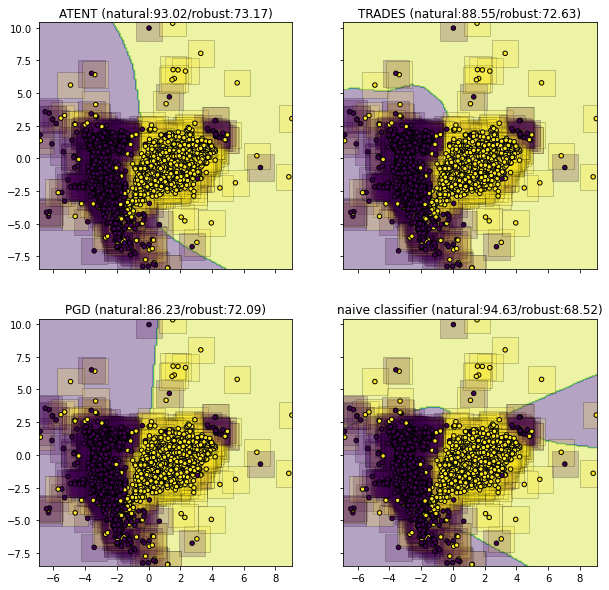

In [58]:
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 10))

for idx, Nettest, tt in zip(product([0, 1], [0, 1]),
                        [model_ATENT,model_TRADES,model_PGD,model_SGD],
                        ['ATENT (natural:'+str(np.around(nat,decimals=2))+'/robust:'+str(np.around(rob,decimals=2))+')', 'TRADES (natural:'+str(np.around(nat1,decimals=2))+'/robust:'+str(np.around(rob1,decimals=2))+')','PGD (natural:'+str(np.around(nat3,decimals=2))+'/robust:'+str(np.around(rob3,decimals=2))+')','naive classifier (natural:'+str(np.around(nat2,decimals=2))+'/robust:'+str(np.around(rob2,decimals=2))+')']):
    plotdata = torch.tensor(np.c_[xx[:tr_ind].ravel(), yy[:tr_ind].ravel()]).unsqueeze(1)
    Z = Nettest(plotdata.float())
    Z = Z.max(dim=1)[1]
    Z = Z.reshape(xx[:tr_ind].shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx].scatter(xdata[:, 0], xdata[:, 1],
                                  s=700, c=ydata, edgecolor='k', marker='s', alpha=0.2)        
    axarr[idx].scatter(xdata[:, 0], xdata[:, 1], c=ydata,
                                  s=20, edgecolor='k')

    axarr[idx].set_title(tt)

plt.show()

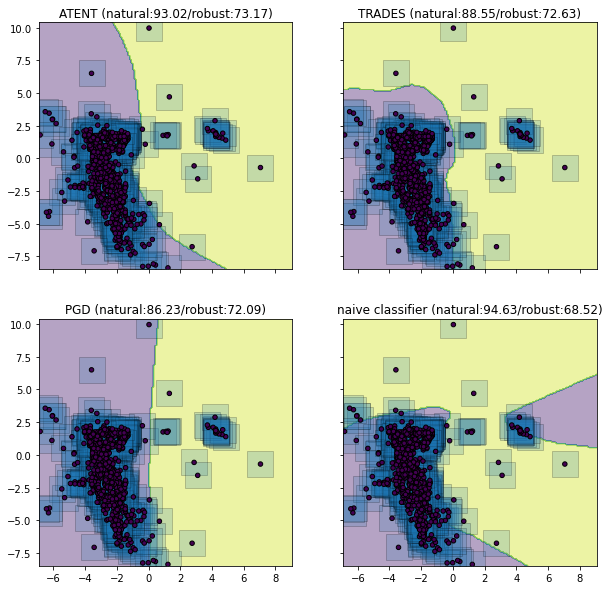

In [46]:
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 10))

for idx, Nettest, tt in zip(product([0, 1], [0, 1]),
                        [model_ATENT,model_TRADES,model_PGD,model_SGD],
                        ['ATENT (natural:'+str(np.around(nat,decimals=2))+'/robust:'+str(np.around(rob,decimals=2))+')', 'TRADES (natural:'+str(np.around(nat1,decimals=2))+'/robust:'+str(np.around(rob1,decimals=2))+')','PGD (natural:'+str(np.around(nat3,decimals=2))+'/robust:'+str(np.around(rob3,decimals=2))+')','naive classifier (natural:'+str(np.around(nat2,decimals=2))+'/robust:'+str(np.around(rob2,decimals=2))+')']):
    plotdata = torch.tensor(np.c_[xx[:tr_ind].ravel(), yy[:tr_ind].ravel()]).unsqueeze(1)
    Z = Nettest(plotdata.float())
    Z = Z.max(dim=1)[1]
    
    Z = Z.reshape(xx[:tr_ind].shape)
    indc = torch.where(ydata==0)
    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx].scatter(xdata[indc][:,0], xdata[indc][:,1],
                                  s=700, edgecolor='k', marker='s', alpha=0.2)        
    axarr[idx].scatter(xdata[indc][:, 0], xdata[indc][:, 1], c=ydata[indc],
                                  s=20, edgecolor='k')

    axarr[idx].set_title(tt)

plt.show()

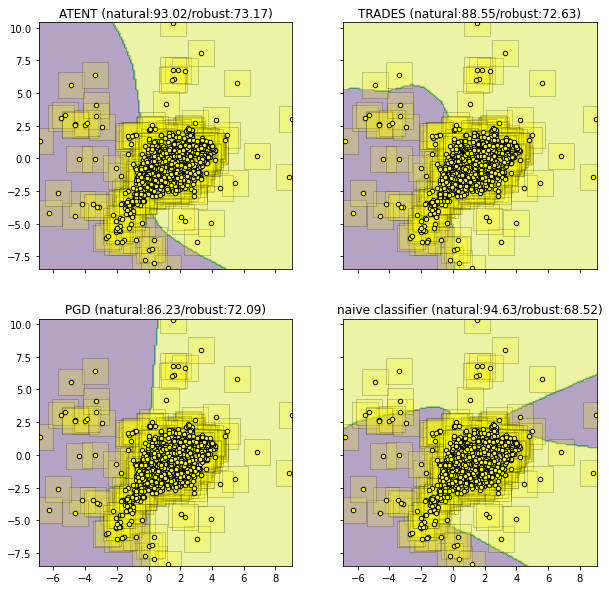

In [55]:
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 10))

for idx, Nettest, tt in zip(product([0, 1], [0, 1]),
                        [model_ATENT,model_TRADES,model_PGD,model_SGD],
                        ['ATENT (natural:'+str(np.around(nat,decimals=2))+'/robust:'+str(np.around(rob,decimals=2))+')', 'TRADES (natural:'+str(np.around(nat1,decimals=2))+'/robust:'+str(np.around(rob1,decimals=2))+')','PGD (natural:'+str(np.around(nat3,decimals=2))+'/robust:'+str(np.around(rob3,decimals=2))+')','naive classifier (natural:'+str(np.around(nat2,decimals=2))+'/robust:'+str(np.around(rob2,decimals=2))+')']):
    plotdata = torch.tensor(np.c_[xx[:tr_ind].ravel(), yy[:tr_ind].ravel()]).unsqueeze(1)
    Z = Nettest(plotdata.float())
    Z = Z.max(dim=1)[1]
    
    Z = Z.reshape(xx[:tr_ind].shape)
    indc = torch.where(ydata==1)
    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx].scatter(xdata[indc][:,0], xdata[indc][:,1],
                                  s=700, edgecolor='k', marker='s', alpha=0.2, c='#FFFF00')        
    axarr[idx].scatter(xdata[indc][:, 0], xdata[indc][:, 1], c='#FFFF00',
                                  s=20, edgecolor='k')

    axarr[idx].set_title(tt)

plt.show()